# BCycle Austin trips

This notebook looks at the bike measurements that were recorded every 5 minutes during April and May 2016. The measurement time of 5 minutes was chosen to balance the amount of data to be recorded, and have a fine enough granularity to capture checkins (when a bike leaves a station) and checkouts (when a bike arrives at a station).

The limitation of the 5-minute sampling period is that if the same amount of bikes arrive and leave a station in a 5-minute period, we won't be able to discern this from the data.

All data was collected from the [BCycle Stations](https://austin.bcycle.com/stations/station-locations) webpage, which is publicly available. No efforts were made to track individuals in the system. The limitation of this approach is that we can't track individual trips, only where bikes were checked in and out.

The data dictionary for the bikes CSV file is below:

* `station_id`: A unique identifier for each of the station. Used to connect the `bikes.csv` time-varying table to the static `stations` table.
* `datetime`: The date and time of the bike measurement.
* `bikes`: How many bikes are available at the station, at this time.
* `docks`: How many docks are available at the station, at this time.


## Imports and data loading

Before getting started, let's import some useful libraries (including the bcycle_lib created for these notebooks), and load the stations CSV file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
bikes_df = load_bikes()
bikes_df.head()

,station_id,datetime,bikes,docks
0,1,2016-04-01,6,7
1,2,2016-04-01,5,8
2,3,2016-04-01,4,9
3,4,2016-04-01,7,11
4,5,2016-04-01,8,11


## Tidy data and Time Series

This dataframe is tricky to deal with, as we have several variables varying throughout. Hadley Wickham has a great paper on [tidy data](http://vita.had.co.nz/papers/tidy-data.pdf) which gives guidelines on how to format data so it can be easily aggregated and used by the tools. The CSV file is already stored in a tidy data format (one measurement per line of docks and bikes), but to calculate checkins and checkouts I need to sort first by `station_id`, and then by `datetime`.

Then I need to segment the dataframe by `station_id` and calculate the diffs between each sample (spaced at 5 minutes). Positive differences in the amount of bikes are defined as checkins, and positive differences in the amount of docks are defined as checkouts.

In [3]:
# Sort the bikes_df dataframe by station_id first, and then datetime so we
# can use a diff() and get the changes by time for each station
bikes_df = bikes_df.sort_values(['station_id', 'datetime'])
stations = bikes_df['station_id'].unique()

# Our dataframe is grouped by station_id first now, so grab each station in
# turn and do a diff() on bikes and docks for each station individually
diff_list = list()
for station in stations:
    station_diff_df = bikes_df[bikes_df['station_id'] == station].copy()
    station_diff_df['bikes_diff'] = station_diff_df['bikes'].diff()
    station_diff_df['docks_diff'] = station_diff_df['docks'].diff()
    diff_list.append(station_diff_df)

# Concatenate the station dataframes back together into a single one.
# Make sure we didn't lose any rows in the process (!)
bikes_diff_df = pd.concat(diff_list)
assert(bikes_df.shape[0] == bikes_diff_df.shape[0]) 
bikes_diff_df.head(10)

,station_id,datetime,bikes,docks,bikes_diff,docks_diff
0,1,2016-04-01 00:00:00,6,7,NaN,NaN
48,1,2016-04-01 00:05:00,6,7,0.0,0.0
96,1,2016-04-01 00:10:00,6,7,0.0,0.0
144,1,2016-04-01 00:15:00,6,7,0.0,0.0
192,1,2016-04-01 00:20:00,6,7,0.0,0.0
240,1,2016-04-01 00:25:00,6,7,0.0,0.0
288,1,2016-04-01 00:30:00,6,7,0.0,0.0
336,1,2016-04-01 00:35:00,6,7,0.0,0.0
384,1,2016-04-01 00:40:00,6,7,0.0,0.0
432,1,2016-04-01 00:45:00,6,7,0.0,0.0


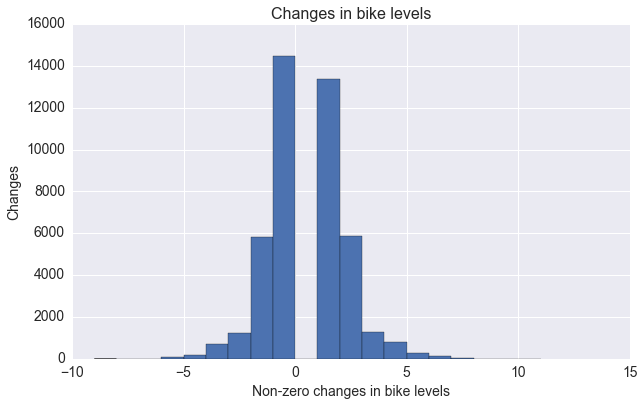

In [4]:
ax = bikes_diff_df[bikes_diff_df['bikes_diff'] != 0]['bikes_diff'].plot.hist(bins=20, figsize=(10,6))
ax.set_xlabel('Non-zero changes in bike levels', fontdict={'size':14})
ax.set_ylabel('Changes', fontdict={'size':14})
ax.set_title('Changes in bike levels', fontdict={'size':16})

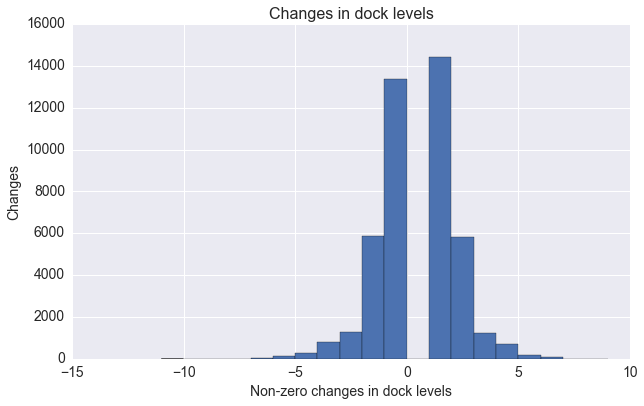

In [5]:
ax = bikes_diff_df[bikes_diff_df['docks_diff'] != 0]['docks_diff'].plot.hist(bins=20, figsize=(10,6))
ax.set_xlabel('Non-zero changes in dock levels', fontdict={'size':14})
ax.set_ylabel('Changes', fontdict={'size':14})
ax.set_title('Changes in dock levels', fontdict={'size':16})

## Aggregating checkins and checkouts by day-of-the week

Now we've examined the checkins and checkouts on a 5-minute basis, we can aggregate the checkins and checkouts by the day of the week and hour. To do this, we need to drop all the negative differences from the `bikes_diff` and `docks_diff` columns. After that, we can aggregate by summing the differences in each hour.

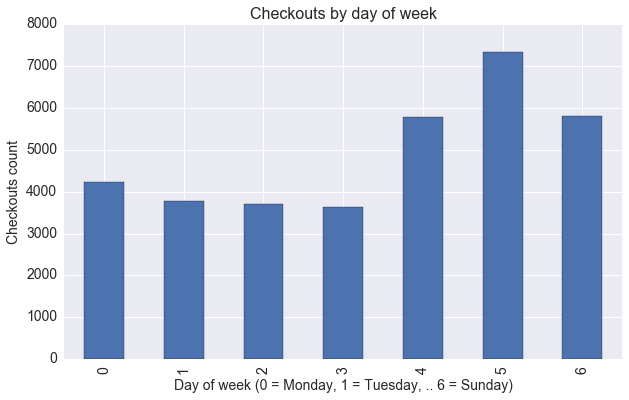

In [6]:
bikes_agg_df = bikes_diff_df.copy()

bikes_agg_df['bikes_diff'] = bikes_agg_df['bikes_diff'].fillna(0)
bikes_agg_df['docks_diff'] = bikes_agg_df['docks_diff'].fillna(0)
bikes_agg_df.loc[bikes_agg_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_agg_df.loc[bikes_agg_df['docks_diff'] < 0, 'docks_diff'] = 0

bikes_agg_df['dayofweek'] = bikes_agg_df['datetime'].dt.dayofweek
bikes_agg_df['weekend'] = bikes_agg_df['datetime'].dt.dayofweek >= 5
bikes_agg_df['hour'] = bikes_agg_df['datetime'].dt.hour

bikes_agg_df = bikes_agg_df.groupby(['dayofweek']).sum().reset_index()
bikes_agg_df = bikes_agg_df[['dayofweek', 'bikes_diff', 'docks_diff']]
bikes_agg_df.columns = ['dayofweek', 'checkins', 'checkouts']

# bikes_agg_df.describe()
bikes_agg_df.head(30)
# bikes_agg_df.iloc[100000:100200]

ax = bikes_agg_df.plot.bar(x='dayofweek', y='checkouts', figsize=(10,6), legend=False)
ax.set_xlabel('Day of week (0 = Monday, 1 = Tuesday, .. 6 = Sunday)', fontdict={'size':14})
ax.set_ylabel('Checkouts count', fontdict={'size':14})
ax.set_title('Checkouts by day of week', fontdict={'size':16})

# g = sns.FacetGrid(data=bikes_agg_df, row="dayofweek", size=4, aspect=2, legend_out=True)
# g = g.map(plt.plot, 'hour', 'checkouts', 'hour', 'checkins')

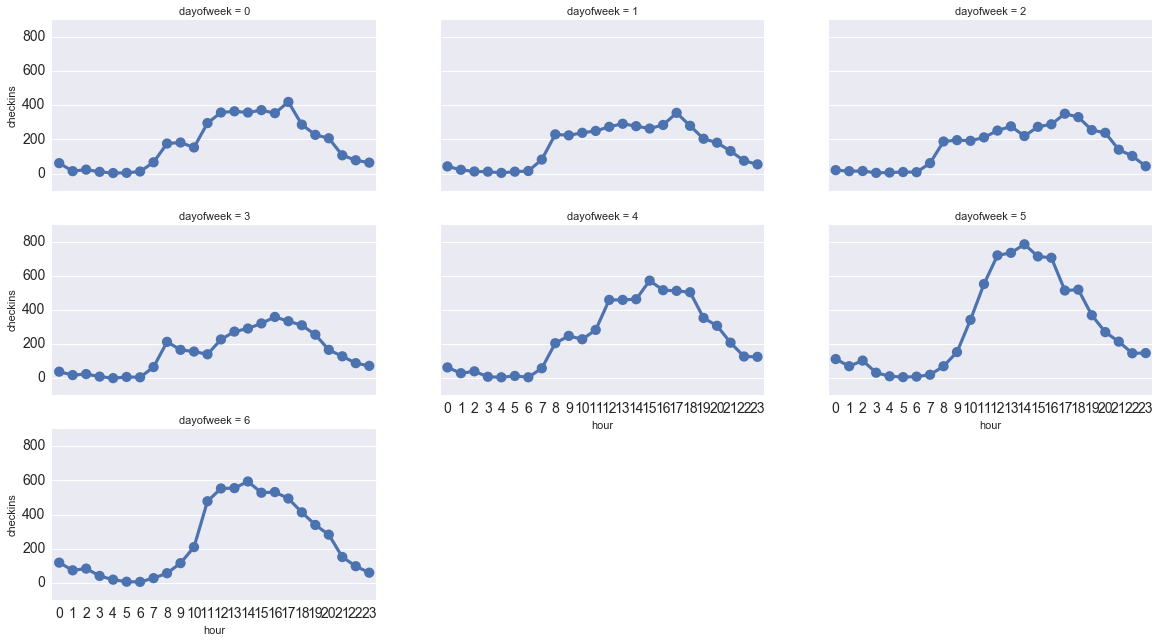

In [7]:
bikes_agg_df = bikes_diff_df.copy()

bikes_agg_df['bikes_diff'] = bikes_agg_df['bikes_diff'].fillna(0)
bikes_agg_df['docks_diff'] = bikes_agg_df['docks_diff'].fillna(0)
bikes_agg_df.loc[bikes_agg_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_agg_df.loc[bikes_agg_df['docks_diff'] < 0, 'docks_diff'] = 0

bikes_agg_df['dayofweek'] = bikes_agg_df['datetime'].dt.dayofweek
bikes_agg_df['weekend'] = bikes_agg_df['datetime'].dt.dayofweek >= 5
bikes_agg_df['hour'] = bikes_agg_df['datetime'].dt.hour

bikes_agg_df = bikes_agg_df.groupby(['dayofweek', 'hour']).sum().reset_index()
bikes_agg_df = bikes_agg_df[['dayofweek', 'hour', 'bikes_diff', 'docks_diff']]
bikes_agg_df.columns = ['dayofweek', 'hour', 'checkins', 'checkouts']

# Plot out the hourly counts by date in a grid
g = sns.factorplot(x="hour", col="dayofweek", col_wrap=3,
                    data=bikes_agg_df,
                    y='checkins', size=3, aspect=1.8)
g.fig.subplots_adjust(wspace=0.2, hspace=0.2)

The plots above show the amount of checkouts aggregated across all the stations on each day of the week, by hour. Monday to Friday show very similar patterns of usage: there's a peak around 7-8AM, usage flattens at around 200 - 400 checkouts per hour during the day, and then tails off to around 0 at midnight. On Friday checkouts are between 400 and 600 between midday and 7PM instead of 200 - 400.

The weekend trends are different. Between midnight and 3AM there are around 100 checkouts per hour, much more than during the week. This is probably due to people spending the night out, and taking a BCycle to get home afterwards. On the weekends, usage shows a much higher peak of 800 checkouts per hour on Saturday and 600 checkouts per hour on Sunday. The initial ramp up on weekends us also later than during the week, occuring at 8AM-9AM instead of 6AM-7AM during the week.

## How many bike trips were there on each day?

Now we've separated out the checkins and checkouts, we can plot out how many checkouts there were on each day during April and May 2016. This tells us how many bike trips were made. We can use pandas' timeseries resampling, which makes this really easy. To keep some granularity of trips during each day, resample to less than a day.

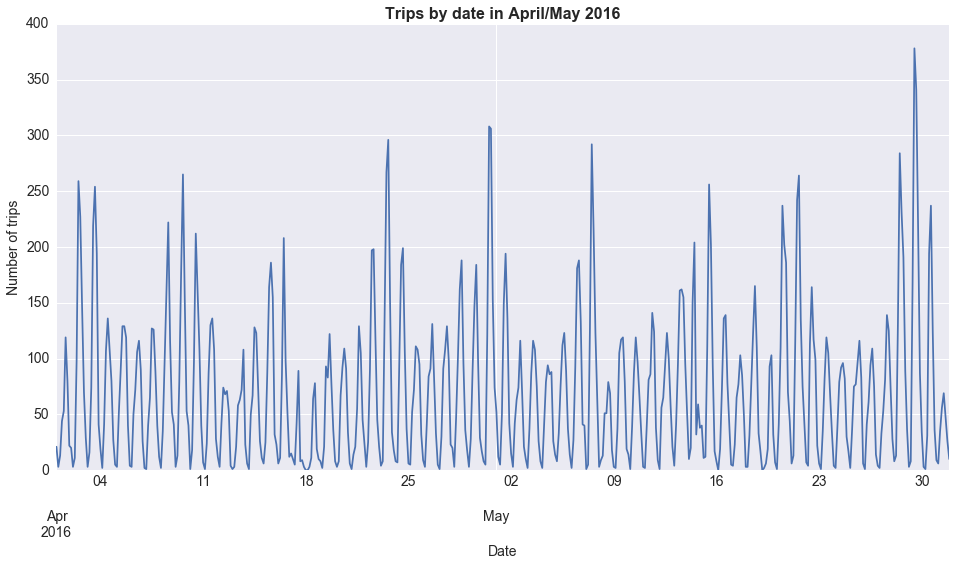

In [13]:
bikes_daily_df = bikes_diff_df.copy()

bikes_daily_df['bikes_diff'] = bikes_daily_df['bikes_diff'].fillna(0)
bikes_daily_df['docks_diff'] = bikes_daily_df['docks_diff'].fillna(0)
bikes_daily_df.loc[bikes_daily_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_daily_df.loc[bikes_daily_df['docks_diff'] < 0, 'docks_diff'] = 0

# bikes_daily_df['dayofyear'] = bikes_daily_df['datetime'].dt.dayofyear
# bikes_daily_df = bikes_daily_df.groupby('dayofyear').sum().reset_index()

bikes_daily_df.index = bikes_daily_df['datetime']
bikes_daily_df = bikes_daily_df.drop(['datetime', 'bikes', 'docks', 'docks_diff'], axis=1)
bikes_daily_df.columns = [['station_id', 'checkouts']]
bikes_daily_df = bikes_daily_df.resample('3H').sum()
bikes_daily_df.head()

ax = bikes_daily_df['checkouts'].plot(figsize=(16,8))
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of trips', fontsize=14)
ax.set_title('Trips by date in April/May 2016', fontdict={'size' : 16, 'weight' : 'bold'})

The plot above shows the amount of trips resampled to 3 hours, smoothing the trip values so the daily variation is visible. As well as the daily variation, there is also a weekly trend where the Friday, Saturday, and Sunday all have larger peaks. There are also some missing peaks, for example around the 18th April, perhaps bad weather was the cause for this drop in trips?

## Comparing stations


In [14]:
bikes_agg_df.head()

,dayofweek,hour,checkins,checkouts
0,0,0,61.0,27.0
1,0,1,14.0,14.0
2,0,2,23.0,23.0
3,0,3,10.0,8.0
4,0,4,3.0,7.0


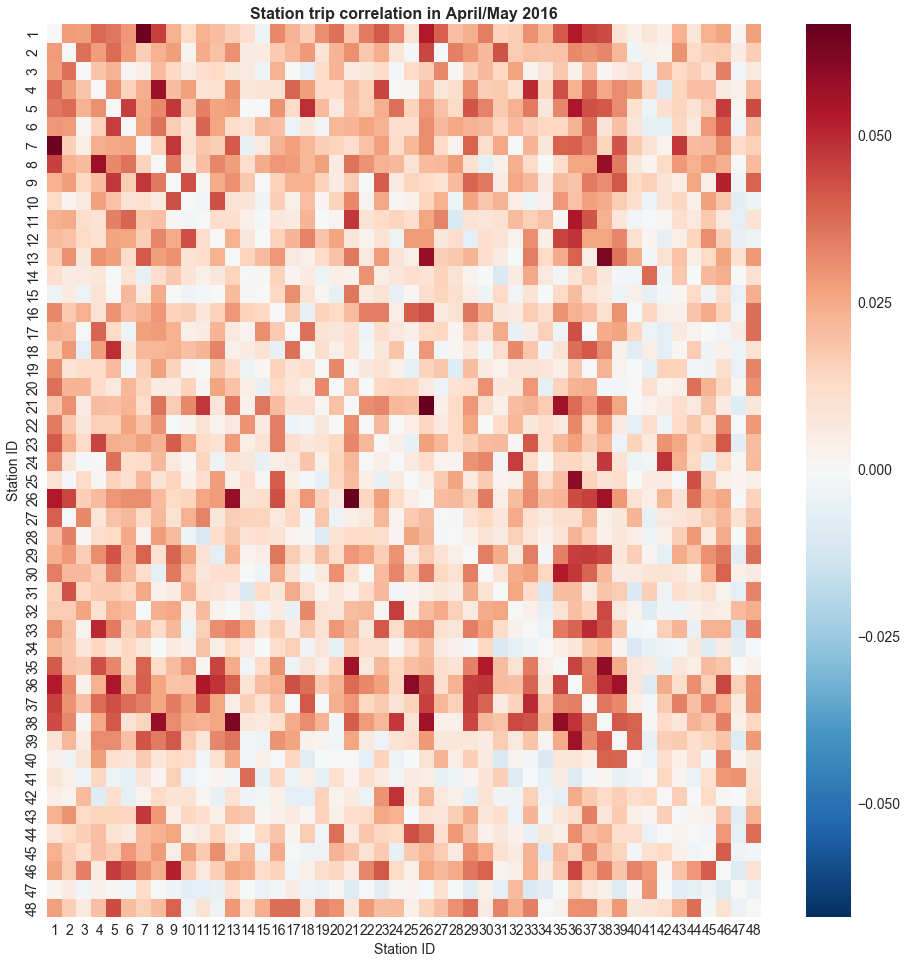

In [60]:
bikes_ts_df = bikes_diff_df.copy()

bikes_ts_df['bikes_diff'] = bikes_ts_df['bikes_diff'].fillna(0)
bikes_ts_df['docks_diff'] = bikes_ts_df['docks_diff'].fillna(0)
bikes_ts_df.loc[bikes_ts_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_ts_df.loc[bikes_ts_df['docks_diff'] < 0, 'docks_diff'] = 0


bikes_ts_df = bikes_ts_df.pivot_table(values='bikes_diff', index='datetime', columns='station_id')

# ax = bikes_ts_df.resample('3H').sum().plot(figsize=(16,8), legend=False)
# ax.set_xlabel('Date', fontsize=14)
# ax.set_ylabel('Number of trips', fontsize=14)
# ax.set_title('Trips by date in April/May 2016', fontdict={'size' : 16, 'weight' : 'bold'})

# Correlation matrix is symmetric with diagonals set to 0
corr_df = bikes_ts_df.corr()
corr_matrix = corr_df.values
corr_matrix -= np.eye(corr_matrix.shape[0]) # Zero the diagonals
corr_matrix = corr_matrix[:48,:48] # Station
# print(corr_matrix)
fig, ax = plt.subplots(1,1, figsize=(16,16))
ax = sns.heatmap(corr_matrix)
ax.set_xlabel('Station ID', fontsize=14)
ax.set_ylabel('Station ID', fontsize=14)
ax.set_xticklabels(range(1,49)) # Need to convert from numpy 0-based index
ax.set_yticklabels(range(48,0, -1)) # to 1-based station_id index
ax.set_title('Station trip time series correlation in April/May 2016', fontdict={'size' : 16, 'weight' : 'bold'})

In [117]:
# Now we have the correlations, let's look at the top 3 correlated pairs of stations, and bottom 3
# TODO ! How to interpret this ?!
# corr_matrix.argsort()


# Pick a station. What are the top 3 correlated stations with it?
# sorted_idx = corr_matrix.argsort(axis=0)
# print(sorted_idx)

# for idx in range()

# corr_stations = dict()

# for corr_row in corr_df.iterrows():
#     row = corr_row[1]
#     sorted_idx = row.argsort()
#     print(sorted_idx)
    
    
#### Warning - everything is zero-indexed as it uses numpy
#### but in the dataframe station ids start at 1

# Create a dictionary with key station_id, value is list of correlated stations
row_idx = corr_matrix.argsort(axis=0)
print(row_idx[0])
print(corr_matrix[:,0])

print('Max {}, min {}'.format(corr_matrix[row_idx[0],0], corr_matrix[row_idx[-1],0]))


[14 39 17 41 40 41 13 29 46 46 27 28 40 30 40 17 41 39 27 33 46 39 46 44 18
 46 40 10 46  7 33 40 46 30 41 40 40 19 46 30 35  3 46 46 33 46 32 46]
[ 0.          0.02856577  0.02814597  0.03855749  0.03587069  0.02960989
  0.06548393  0.04558721  0.02374945  0.01313074  0.02362026  0.02080744
  0.01648441  0.01114225 -0.00351657  0.03195956  0.02307999  0.01626125
  0.03128914  0.03691294  0.018383    0.03470215  0.04095833  0.03147495
  0.00990356  0.05376695  0.04015379  0.02029165  0.02445706  0.03407173
  0.01542711  0.01687181  0.0307929   0.02208629  0.04097756  0.05368297
  0.04555189  0.04343805  0.00938092  0.0033062   0.00849296  0.00487399
  0.02397946  0.0088258   0.02373639  0.02709503  0.00127848  0.02729334]
Max [-0.00351657  0.0033062   0.01626125  0.00487399  0.00849296  0.00487399
  0.01114225  0.03407173  0.00127848  0.00127848  0.02029165  0.02445706
  0.00849296  0.01542711  0.00849296  0.01626125  0.00487399  0.0033062
  0.02029165  0.02208629  0.00127848  0.003306